# 1.8b: Core Structure (bfloat16)

**The Key Insight:** Black holes are tokens with **identical bfloat16 embeddings** after centering at the core centroid.

**The Approach:**
1. Work entirely in bfloat16 (W's native precision)
2. Center at core centroid in bfloat16
3. Extract coordinates (x, y, z) from high-variance dimensions
4. Compute r² = x² + y² + z² (no sqrt needed!)
5. Group tokens by identical (r², x, y, z) in bfloat16
6. Black holes = groups with > 1 token

**Why bfloat16?** Float32 adds fake precision that obscures the quantized structure. We want to see the actual lattice where embeddings live.

## Parameters

In [56]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Visualization
DPI = 200

## Imports

In [57]:
import torch
import matplotlib.pyplot as plt
import ml_dtypes
import numpy as np
from collections import defaultdict
from safetensors.torch import load_file
from pathlib import Path

# Helper function to convert PyTorch bfloat16 to ml_dtypes.bfloat16
def torch_bf16_to_numpy_bf16(tensor):
    """Convert PyTorch bfloat16 tensor to numpy array with ml_dtypes.bfloat16 dtype."""
    # View as uint16 (raw bits), convert to numpy, then view as bfloat16
    return tensor.cpu().view(torch.uint16).numpy().view(ml_dtypes.bfloat16)

## Load Data (bfloat16)

In [58]:
# Load W in native bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W from {W_path}")
print(f"  Shape: {W_bf16.shape}")
print(f"  Dtype: {W_bf16.dtype}")
print(f"  ✓ Staying in bfloat16!")

# Load core data from 1.8a
core_path = Path(f"../tensors/{MODEL_NAME}/1.8a_core.safetensors")
core_data = load_file(core_path)

core_mask = core_data["core_mask"].to(torch.bool)
core_token_ids = core_data["core_token_ids"].to(torch.int64)
n_core = core_data["n_core"].item()

# Basis indices from 1.8a (computed in float32, but we'll use them)
north_idx = core_data["north_idx"].item()
meridian_idx = core_data["meridian_idx"].item()
equinox_idx = core_data["equinox_idx"].item()

print(f"\nLoaded core from {core_path}")
print(f"  Core size: {n_core:,} tokens")
print(f"  Basis dimensions: {meridian_idx}, {north_idx}, {equinox_idx}")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  ✓ Staying in bfloat16!

Loaded core from ../tensors/Qwen3-4B-Instruct-2507/1.8a_core.safetensors
  Core size: 2,179 tokens
  Basis dimensions: 322, 163, 1564


## Extract Core in bfloat16

In [59]:
print("\nExtracting core embeddings (bfloat16)...\n")

# Extract core embeddings (stay in bfloat16)
W_core_bf16 = W_bf16[core_mask]

print(f"✓ Extracted {W_core_bf16.shape[0]:,} core embeddings")
print(f"  Dtype: {W_core_bf16.dtype}")


Extracting core embeddings (bfloat16)...

✓ Extracted 2,179 core embeddings
  Dtype: torch.bfloat16


## Compute Core Centroid (bfloat16)

In [60]:
print("\nComputing core centroid (bfloat16)...\n")

# Compute centroid in bfloat16
core_centroid_bf16 = W_core_bf16.mean(dim=0)

print(f"Core centroid:")
print(f"  Dtype: {core_centroid_bf16.dtype}")
print(f"  Norm: {core_centroid_bf16.norm().item():.8f}")
print(f"\n✓ Centroid computed in bfloat16")


Computing core centroid (bfloat16)...

Core centroid:
  Dtype: torch.bfloat16
  Norm: 0.37109375

✓ Centroid computed in bfloat16


## Center Core (bfloat16)

In [61]:
print("\nCentering core at centroid (bfloat16)...\n")

# Center in bfloat16
W_core_centered_bf16 = W_core_bf16 - core_centroid_bf16

print(f"✓ Centered core")
print(f"  Dtype: {W_core_centered_bf16.dtype}")
print(f"  Mean norm: {W_core_centered_bf16.mean(dim=0).norm().item():.2e}")


Centering core at centroid (bfloat16)...

✓ Centered core
  Dtype: torch.bfloat16
  Mean norm: 7.33e-06


## Extract Coordinates (bfloat16)

In [62]:
print("\nExtracting coordinates from basis dimensions (bfloat16)...\n")

# Extract x, y, z (stay in bfloat16)
x_bf16 = W_core_centered_bf16[:, meridian_idx]
y_bf16 = W_core_centered_bf16[:, equinox_idx]
z_bf16 = W_core_centered_bf16[:, north_idx]

print(f"✓ Extracted coordinates")
print(f"  x dtype: {x_bf16.dtype}")
print(f"  y dtype: {y_bf16.dtype}")
print(f"  z dtype: {z_bf16.dtype}")
print()
print(f"Coordinate ranges:")
print(f"  x: [{x_bf16.min().item():.6e}, {x_bf16.max().item():.6e}]")
print(f"  y: [{y_bf16.min().item():.6e}, {y_bf16.max().item():.6e}]")
print(f"  z: [{z_bf16.min().item():.6e}, {z_bf16.max().item():.6e}]")


Extracting coordinates from basis dimensions (bfloat16)...

✓ Extracted coordinates
  x dtype: torch.bfloat16
  y dtype: torch.bfloat16
  z dtype: torch.bfloat16

Coordinate ranges:
  x: [-1.525879e-05, 1.525879e-05]
  y: [0.000000e+00, 1.525879e-05]
  z: [-4.882812e-04, 0.000000e+00]


## Compute r² (bfloat16)

In [63]:
print("\nComputing r² = x² + y² + z² (bfloat16)...\n")

# Compute squared radius in bfloat16
r_squared_bf16 = x_bf16**2 + y_bf16**2 + z_bf16**2

print(f"✓ Computed r²")
print(f"  Dtype: {r_squared_bf16.dtype}")
print(f"  Range: [{r_squared_bf16.min().item():.6e}, {r_squared_bf16.max().item():.6e}]")
print(f"  Median: {r_squared_bf16.median().item():.6e}")


Computing r² = x² + y² + z² (bfloat16)...

✓ Computed r²
  Dtype: torch.bfloat16
  Range: [2.328306e-10, 2.384186e-07]
  Median: 2.328306e-10


## Find Unique (r², x, y, z) Tuples

In [64]:
print("\nGrouping tokens by identical (r², x, y, z) in bfloat16...\n")

# Create coordinate tuples
coords_bf16 = torch.stack([r_squared_bf16, x_bf16, y_bf16, z_bf16], dim=1)

# Convert to numpy bfloat16 using helper
coords_np_bf16 = torch_bf16_to_numpy_bf16(coords_bf16)

# Group tokens by coordinate tuple
# Use a dict mapping coordinate tuple -> list of token indices
coord_groups = defaultdict(list)

for i in range(n_core):
    # Convert row to tuple for hashing (stays as bfloat16 values)
    coord_tuple = tuple(coords_np_bf16[i])
    coord_groups[coord_tuple].append(i)

# Analyze groups
n_unique = len(coord_groups)
group_sizes = [len(indices) for indices in coord_groups.values()]
n_black_holes = sum(1 for size in group_sizes if size > 1)

print(f"Unique coordinate tuples: {n_unique:,}")
print(f"Black holes (groups with >1 token): {n_black_holes:,}")
print(f"Singleton tokens: {n_unique - n_black_holes:,}")
print()
print(f"Group size distribution:")
print(f"  Min: {min(group_sizes)}")
print(f"  Max: {max(group_sizes)}")
print(f"  Mean: {np.mean(group_sizes):.2f}")


Grouping tokens by identical (r², x, y, z) in bfloat16...

Unique coordinate tuples: 5
Black holes (groups with >1 token): 4
Singleton tokens: 1

Group size distribution:
  Min: 1
  Max: 866
  Mean: 435.80


## Black Hole Catalog

In [65]:
print("\nCataloging black holes...\n")

# Sort groups by size (descending)
sorted_groups = sorted(coord_groups.items(), key=lambda x: len(x[1]), reverse=True)

# Filter to black holes only (size > 1)
black_holes = [(coord, indices) for coord, indices in sorted_groups if len(indices) > 1]

print(f"Black hole catalog ({len(black_holes)} black holes):")
print(f"{'Rank':<6} {'Size':<10} {'r²':<15} {'x':<15} {'y':<15} {'z'}")
print("-" * 85)

for rank, (coord, indices) in enumerate(black_holes[:20], 1):
    r2, x, y, z = coord
    size = len(indices)
    
    # Convert bfloat16 to float for formatting
    r2_f = float(r2)
    x_f = float(x)
    y_f = float(y)
    z_f = float(z)
    
    print(f"{rank:<6} {size:<10,} {r2_f:<15.6e} {x_f:<15.6e} {y_f:<15.6e} {z_f:.6e}")

if len(black_holes) > 20:
    print(f"... and {len(black_holes) - 20} more black holes")


Cataloging black holes...

Black hole catalog (4 black holes):
Rank   Size       r²              x               y               z
-------------------------------------------------------------------------------------
1      866        2.328306e-10    -1.525879e-05   0.000000e+00    0.000000e+00
2      734        4.656613e-10    1.525879e-05    1.525879e-05    0.000000e+00
3      329        2.328306e-10    1.525879e-05    0.000000e+00    0.000000e+00
4      249        4.656613e-10    -1.525879e-05   1.525879e-05    0.000000e+00


## Visualize: r² Distribution


Plotting r² distribution...



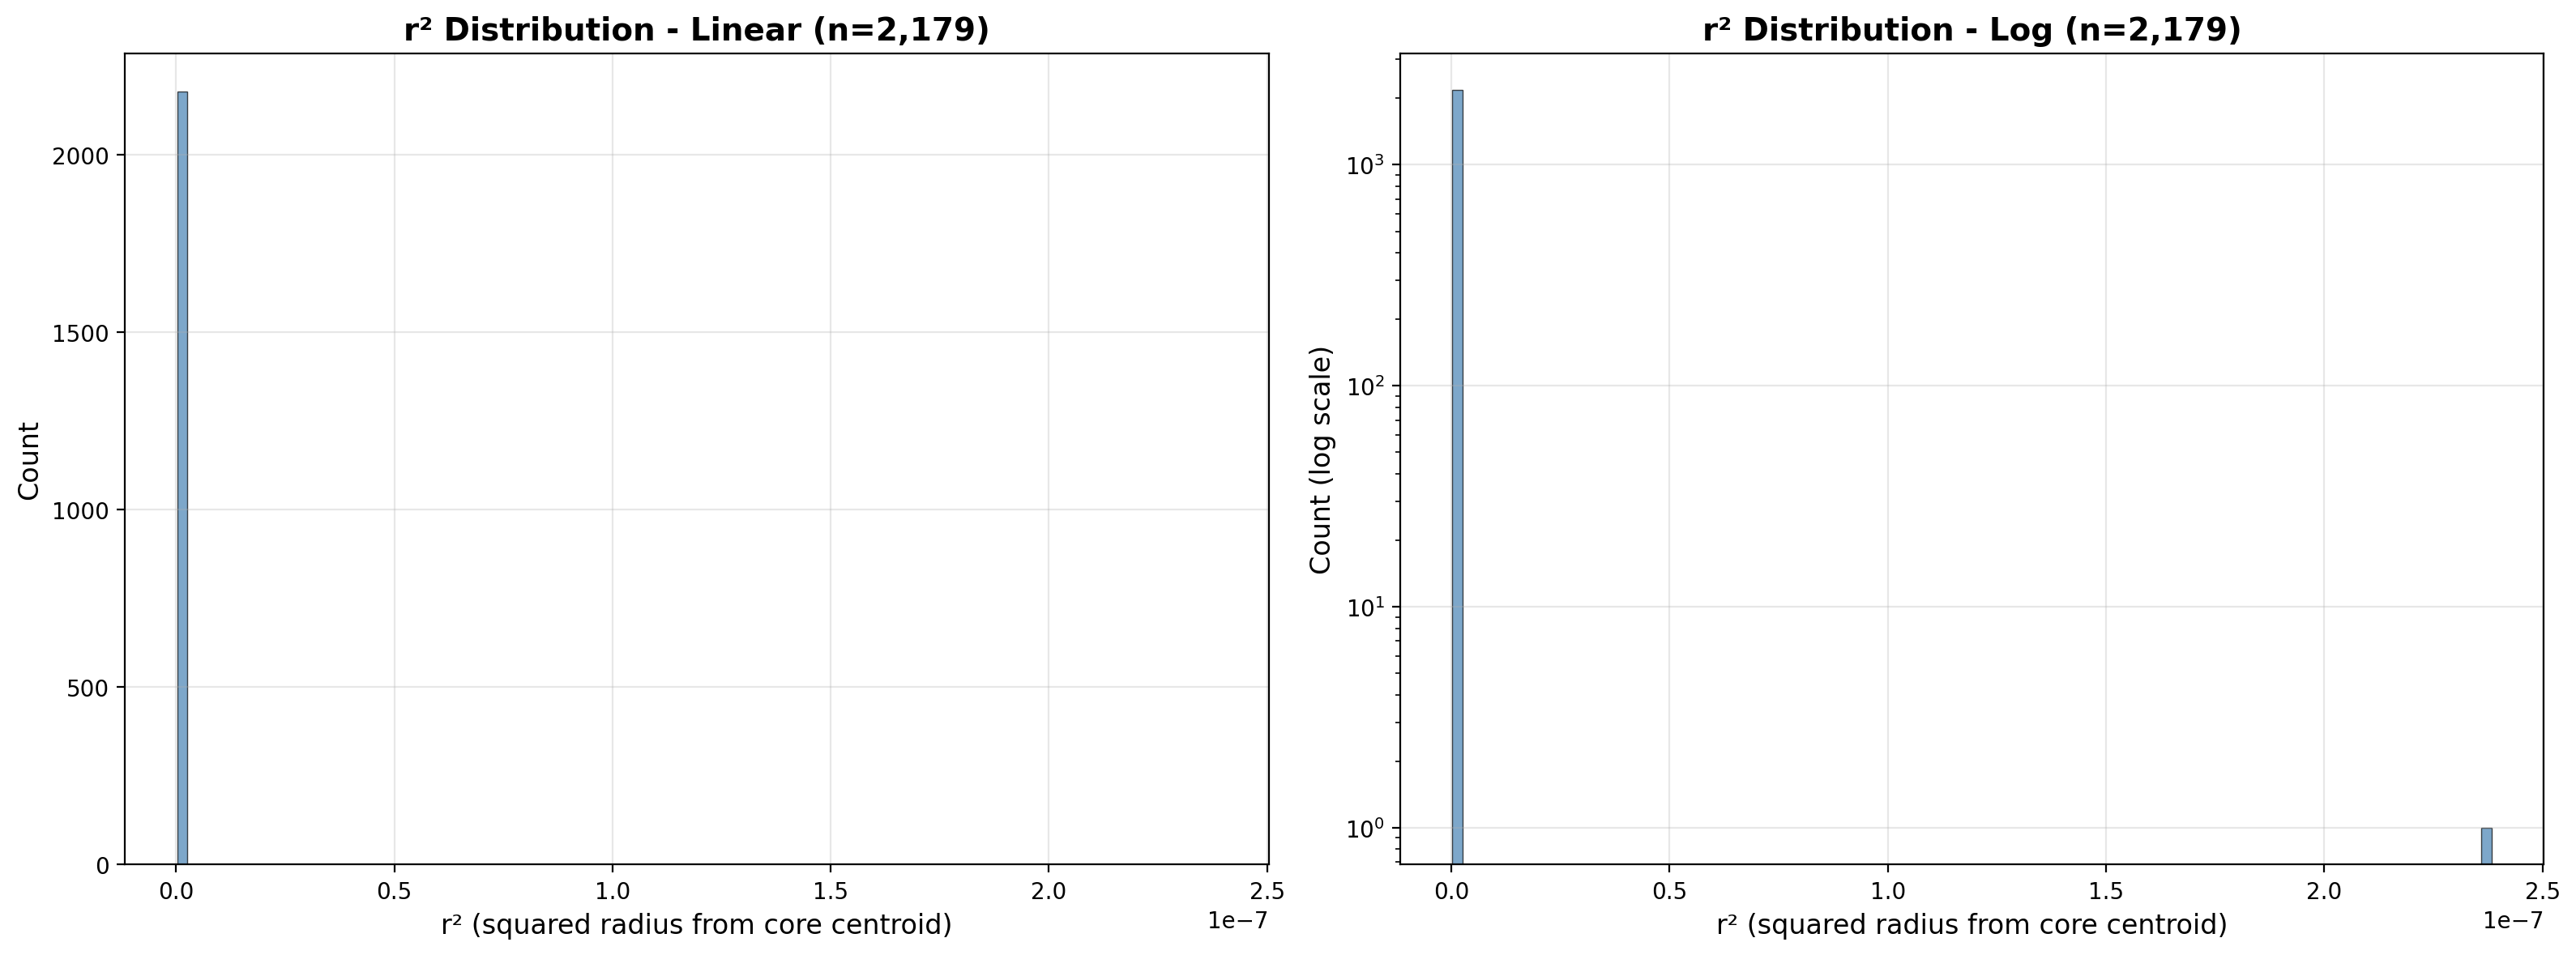

✓ Plotted r² distribution
  Discrete spikes = black holes (multiple tokens at same r²)


In [66]:
print("\nPlotting r² distribution...\n")

# Convert to numpy bfloat16, then to float32 for plotting
r2_np_bf16 = torch_bf16_to_numpy_bf16(r_squared_bf16)
r2_np_f32 = r2_np_bf16.astype(np.float32)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=DPI)

# Linear scale
ax1.hist(r2_np_f32, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('r² (squared radius from core centroid)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title(f'r² Distribution - Linear (n={n_core:,})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Log scale
ax2.hist(r2_np_f32, bins=100, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('r² (squared radius from core centroid)', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title(f'r² Distribution - Log (n={n_core:,})', fontsize=14, fontweight='bold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Plotted r² distribution")
print("  Discrete spikes = black holes (multiple tokens at same r²)")

## Unique r² Values

In [67]:
print("\nAnalyzing unique r² values...\n")

unique_r2, counts_r2 = torch.unique(r_squared_bf16, return_counts=True)

# Sort by count
sort_idx = counts_r2.argsort(descending=True)
unique_r2_sorted = unique_r2[sort_idx]
counts_r2_sorted = counts_r2[sort_idx]

print(f"Total unique r² values: {len(unique_r2):,}")
print(f"\nTop 20 most common r² values:")
print(f"{'Rank':<6} {'r²':<18} {'Count':<10} {'% of core'}")
print("-" * 55)

for rank in range(min(20, len(unique_r2_sorted))):
    r2 = unique_r2_sorted[rank].item()
    count = counts_r2_sorted[rank].item()
    pct = count / n_core * 100
    
    marker = " ← SHELL" if count > 1 else ""
    print(f"{rank+1:<6} {r2:<18.10e} {count:<10,} {pct:>5.1f}%{marker}")


Analyzing unique r² values...

Total unique r² values: 3

Top 20 most common r² values:
Rank   r²                 Count      % of core
-------------------------------------------------------
1      2.3283064365e-10   1,195       54.8% ← SHELL
2      4.6566128731e-10   983         45.1% ← SHELL
3      2.3841857910e-07   1            0.0%


## Sample Black Hole Members

In [68]:
print("\nSample black hole membership (largest black hole):")
print()

if len(black_holes) > 0:
    # Get largest black hole
    largest_coord, largest_indices = black_holes[0]
    r2, x, y, z = largest_coord
    
    # Convert to float for display
    r2_f = float(r2)
    x_f = float(x)
    y_f = float(y)
    z_f = float(z)
    
    print(f"Largest black hole:")
    print(f"  Size: {len(largest_indices):,} tokens")
    print(f"  Coordinates: r²={r2_f:.6e}, x={x_f:.6e}, y={y_f:.6e}, z={z_f:.6e}")
    print()
    print(f"First 20 member tokens:")
    print(f"{'Index':<8} {'Token ID'}")
    print("-" * 20)
    
    for i, idx in enumerate(largest_indices[:20]):
        token_id = core_token_ids[idx].item()
        print(f"{i+1:<8} {token_id}")
    
    if len(largest_indices) > 20:
        print(f"... and {len(largest_indices) - 20} more tokens")
else:
    print("No black holes found!")


Sample black hole membership (largest black hole):

Largest black hole:
  Size: 866 tokens
  Coordinates: r²=2.328306e-10, x=-1.525879e-05, y=0.000000e+00, z=0.000000e+00

First 20 member tokens:
Index    Token ID
--------------------
1        80091
2        119346
3        119348
4        119349
5        123806
6        123828
7        123870
8        124027
9        124033
10       124055
11       124060
12       124083
13       124084
14       124105
15       124132
16       124139
17       124212
18       124238
19       124254
20       124258
... and 846 more tokens


## Summary

In [69]:
print("\n" + "="*60)
print("CORE STRUCTURE SUMMARY (bfloat16 precision)")
print("="*60)
print()
print(f"Core size: {n_core:,} tokens")
print(f"Unique coordinate tuples: {n_unique:,}")
print(f"Black holes (>1 token at same coordinates): {n_black_holes:,}")
print(f"Singleton tokens: {n_unique - n_black_holes:,}")
print()
if len(black_holes) > 0:
    print(f"Largest black hole: {max(group_sizes):,} tokens")
    print(f"Smallest black hole: {min(size for size in group_sizes if size > 1)} tokens")
    print()
    print(f"Black hole size distribution:")
    bh_sizes = sorted([len(indices) for _, indices in black_holes], reverse=True)
    print(f"  Top 5: {bh_sizes[:5]}")
print()
print("="*60)


CORE STRUCTURE SUMMARY (bfloat16 precision)

Core size: 2,179 tokens
Unique coordinate tuples: 5
Black holes (>1 token at same coordinates): 4
Singleton tokens: 1

Largest black hole: 866 tokens
Smallest black hole: 249 tokens

Black hole size distribution:
  Top 5: [866, 734, 329, 249]

